In [1]:
import sys
sys.executable = '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8/site-packages'
python_path = ['/home/chao/cantera/build/python', '/home/chao/RMG-Py', '/home/chao', '/home/chao/anaconda3/envs/chemcheck_env/lib/python38.zip', '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8', '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8/lib-dynload', '/home/chao/anaconda3/envs/chemcheck_env/lib/python3.8/site-packages']
sys.path.clear()
for path in python_path:
    sys.path.append(path)

In [2]:
import cantera as ct
import yaml
import math
import numpy as np

In [4]:
gas = ct.Solution('/home/chao/cantera/data/bm_ptcombust.yaml')
surf1 = ct.Interface('/home/chao/cantera/data/bm_ptcombust.yaml', 'Pt_surf', [gas])
r1 = ct.BMInterfaceReaction()
r1.reactants = 'H(S):2' 
r1.products = 'H2:1, PT(S):2'
r1.rate = ct.BlowersMasel(3.7e20, 0, 67.4e6, 1e9)
r1.coverage_deps = {'H(S)': (0, 0, -6e6)}
surf_species = []
for species in surf1.species():
    surf_species.append(species)
surf2 = ct.Interface(thermo='Surface', species=surf_species,
                     kinetics='interface', reactions=[r1], adjacent=[gas])

surf2.site_density = surf1.site_density
surf2.coverages = surf1.coverages = 'PT(S):0.7, H(S):0.3'
gas.TP = surf2.TP = surf1.TP
for T in [300, 500, 1500]:
    gas.TP = surf1.TP = surf2.TP = T, 5*ct.one_atm
    print(surf1.forward_rate_constants[1], surf1.equilibrium_constants[1], surf2.forward_rate_constants[0], surf2.equilibrium_constants[0])
    print(surf1.net_rates_of_progress[1], surf2.net_rates_of_progress[0])

78.94079453762959 5.145642419618732e-08 78.94079453762959 5.145642419618732e-08
5.2035038205266265e-15 5.2035038205266265e-15
1364320102.5464253 0.004772073330066372 1364320102.5464253 0.004772073330066372
8.993125680585248e-08 8.993125680585248e-08
7.8135602956555e+16 307.8504089251634 7.8135602956555e+16 307.8504089251634
5.1504283797115455 5.1504283797115455


In [19]:
surf1.net_rates_of_progress

array([0.0980161, 0.02082  , 0.       ])

In [35]:
surf1.reaction(1).rate

BlowersMasel(A=3.7e+20, b=0, Ea0=6.74e+07, w=1e+09)

In [37]:
bm_rate_(3.7e+20,0, 6.74e+07,1e+09, surf1.delta_enthalpy[1], 500)

136255508.27297282

In [39]:
surf2.forward_rate_constants

array([1.36255508e+08])

In [6]:
yaml_file = '/home/chao/bm_test/bm_example.yml'
gas = ct.Solution(yaml_file)

In [4]:
gas.reaction(0).rate

BlowersMasel(A=38.7, b=2.7, E_intrinsic=2.61918e+07, w=4.184e+12)

In [5]:
with open(yaml_file, 'r') as f:
    content = yaml.load(f, Loader=yaml.FullLoader)
rate_constant = content['reactions'][0]['rate-constant']
A = rate_constant['A']
b = rate_constant['b']
E = format(rate_constant['Ea'] * 4.184e3, 'e')
w = format(float(rate_constant['w']) * 4.184e3, 'e')
print(f'A:{A}, b:{b}, E:{E}, w:{w} in J/kmol')

A:38700.0, b:2.7, E:2.619184e+07, w:4.184000e+12 in J/kmol


In [6]:
def bm_rate(bm_string, deltaH, T):
    bm_list = bm_string.split()
    A = float(bm_list[0][15:-1])
    b = float(bm_list[1][2:-1])
    E = float(bm_list[2][12:-1])
    w = float(bm_list[3][2:-1]) 
    R = 8314.46261815324 # J/ (kmol.K)
#     print(A, b, E, w)
    if deltaH < -4 * E:
        E = 0 
    elif deltaH > 4 * E:
        E = deltaH
    else:
        vp = 2 * w * (w+E) / (w - E)
        E = (w + deltaH / 2) * (vp - 2 * w + deltaH) ** 2 / (vp ** 2 - 4 * w ** 2 + deltaH ** 2)
    
    rate = A * T ** b * math.exp(-E / (R * T))
    print(f'A: {A}, b:{b}, E:{E}, w:{w}')
    return rate

In [8]:
rate = str(gas.reaction(0).rate)
print(bm_rate(rate, gas.delta_enthalpy[0], gas.T))
print(gas.forward_rate_constants[0])

A: 38.7, b:2.7, E:30436227.976852942, w:4184000000000.0
947.5972374450457
947.5821341065912


In [34]:
def bm_rate_(A, b, E0, w, deltaH, T):

    R = 8314.46261815324 # J/ (kmol.K)
#     print(A, b, E, w)
    if deltaH < -4 * E0:
        E = 0 
    elif deltaH > 4 * E0:
        E = deltaH
    else:
        vp = 2 * w * (w+E0) / (w - E0)
        E = (w + deltaH / 2) * (vp - 2 * w + deltaH) ** 2 / (vp ** 2 - 4 * w ** 2 + deltaH ** 2)
    
    rate = A * T ** b * math.exp(-E / (R * T))
#     print(f'A: {A}, b:{b}, E:{E}, w:{w}')
    return rate

In [17]:
with open(yaml_file, 'r') as f:
    content = yaml.load(f, Loader=yaml.FullLoader)
rate_constant = content['reactions'][0]['rate-constant']
A = rate_constant['A'] / 1000
b = rate_constant['b']
E0 = rate_constant['Ea'] * 4.184e3
w = float(rate_constant['w']) * 4.184e3
print(f'A:{A}, b:{b}, E:{E}, w:{w} in J/kmol')

A:38.7, b:2.7, E:2.619184e+07, w:4184000000000.0 in J/kmol


In [18]:
bm_rate_(A, b, E0, w, float(gas.delta_enthalpy[0]), gas.T)

947.5821340199202

In [18]:
for i in range(2, 10, 2):
    print(i, end=', ')

2, 4, 6, 8, 

The first and second reactions have same reaction equation, but they have different reaction types, so the forward rate constant of the first reaction is 5195.447 kmol/(m^3.s), the forward rate constant of the second reaction is 946.051 kmol/(m^3.s).
The rate parameters of second and the third reactions are same, but the forward rate cosntant of second reaction is 946.051 kmol/(m^3.s), the forward rate constant of the third reaction is 2533.800 kmol/(m^3.s).


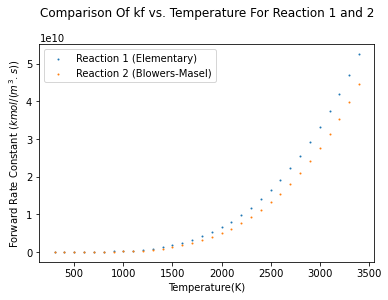

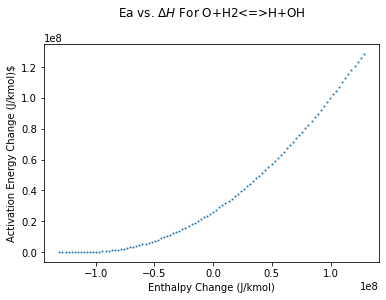

In [2]:
"""
A simplest example to demonstrate the difference between Blowers-Masel
reaction and elementary reaction. The first two reactions have same reaction 
equations with Arrhenius and Blowers-Masel rate parameters, respectively. 
The Blowers-Masel parameters are same as Arrhenius parameters with an 
additional value, bond energy. First we show that the forward rate constants 
of the first 2 different reactions are different because of the different rate
expression, then we print the forward rate constants for reaction 2 and reaction 3
to show that even 2 reactions have same Blowers-Masel parameters can have different
forward rate constants. The first plot generated shows the rate constant changes
with respect to temperature for elementary and Blower-Masel reactions are different.
The second plot shows the activation energy change of a Blowers-Masel reaction 
with respect to the delta enthalpy of the reaction.
"""

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

#Create an elementary reaction O+H2<=>H+OH
r1 = ct.ElementaryReaction({'O':1, 'H2':1}, {'H':1, 'OH':1})
r1.rate = ct.Arrhenius(3.87e1, 2.7, 6260*1000*4.184)

#Create a gas-phase Blowers-Masel reaction O+H2<=>H+OH
r2 = ct.BlowersMaselReaction({'O':1, 'H2':1}, {'H':1, 'OH':1})
r2.rate = ct.BlowersMasel(3.87e1, 2.7, 6260*1000*4.184, 1e9)

#Create a Blowers-Masel reaction with same parameters with r2
#reaction equation is H+CH4<=>CH3+H2
r3 = ct.BlowersMaselReaction({'H':1, 'CH4':1}, {'CH3':1, 'H2':1})
r3.rate = ct.BlowersMasel(3.87e1, 2.7, 6260*1000*4.184, 1e9)

gas = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                   species=ct.Solution('gri30.yaml').species(), reactions=[r1, r2, r3])

gas.TP = 300, ct.one_atm

r1_rc = gas.forward_rate_constants[0]
r2_rc = gas.forward_rate_constants[1]
r3_rc = gas.forward_rate_constants[2]

print("The first and second reactions have same reaction equation,"
      " but they have different reaction types, so the forward rate" 
      " constant of the first reaction is {0:.3f} kmol/(m^3.s)," 
      " the forward rate constant of the second reaction is {1:.3f} kmol/(m^3.s).".format(r1_rc, r2_rc))

# Comparing the second and the third rate constants shows that
# even the rate parameters are same, the rate constants are 
# different due to the enthalpy change of the reactions are different
print("The rate parameters of second and the third reactions are same,"
      " but the forward rate cosntant of second reaction is {0:.3f} kmol/(m^3.s),"
      " the forward rate constant of the third reaction is" 
      " {1:.3f} kmol/(m^3.s).".format(r2_rc, r3_rc))

# Comparing the reaction forward rate constant change of 
# Blowers-Masel reaction and elementary reaction with
# respect to the temperature.
r1_kf = []
r2_kf = []
T_range = np.arange(300, 3500, 100)
for temp in T_range:
    gas.TP = temp, ct.one_atm
    r1_kf.append(gas.forward_rate_constants[0])
    r2_kf.append(gas.forward_rate_constants[1])
plt.scatter(T_range, r1_kf, 1*1, label='Reaction 1 (Elementary)')
plt.scatter(T_range, r2_kf, 1*1, label='Reaction 2 (Blowers-Masel)')
plt.xlabel("Temperature(K)")
plt.ylabel("Forward Rate Constant $(kmol/(m^3.s))$")
plt.title("Comparison Of kf vs. Temperature For Reaction 1 and 2",y=1.1)
plt.legend()
plt.show()

# This is the function to change the enthalpy of a species
# so that the enthalpy change of reactions involving this
#species can be changed
def change_species_enthalpy(gas, species_name, dH):
    """
    Find the species by name and change it's enthlapy by dH (in J/kmol)
    """
    index = gas.species_index(species_name)

    species = gas.species(index)
    # 'dx' is in fact (delta H / R). Note that R in cantera is 8314.462 J/kmol
    dx = dH / ct.gas_constant  
    perturbed_coeffs = species.thermo.coeffs.copy()
    perturbed_coeffs[6] += dx
    perturbed_coeffs[13] += dx
    
    species.thermo = ct.NasaPoly2(species.thermo.min_temp, species.thermo.max_temp, 
                            species.thermo.reference_pressure, perturbed_coeffs)

    gas.modify_species(index, species)
    
# Plot the activation energy change of reaction 2 with respect to the 
# enthalpy change
E0 = float(str(gas.reaction(1).rate).split()[-2][3:-1])
upper_limit_enthalpy = 5 * E0
lower_limit_enthalpy = -5 * E0

Ea_list = []
deltaH_list = np.arange(lower_limit_enthalpy, upper_limit_enthalpy, (upper_limit_enthalpy-lower_limit_enthalpy)/100)
for deltaH in deltaH_list:
    change_species_enthalpy(gas, 'H', deltaH - gas.delta_enthalpy[1])
    Ea_list.append(gas.reaction(1).rate.activation_energy(gas.delta_enthalpy[1]))

plt.scatter(deltaH_list, Ea_list, 1)
plt.xlabel("Enthalpy Change (J/kmol)")
plt.ylabel("Activation Energy Change (J/kmol)$")
plt.title("Ea vs. $\Delta H$ For O+H2<=>H+OH", y=1.1)
plt.show()


In [4]:
E0 = float(str(gas.reaction(1).rate).split()[-2][3:-1])
print(E0)

26191800.0


In [5]:
big_enthalpy = 5 * E0
mid_enthalpy = 2 * E0
small_enthalpy = -5 * E0

In [6]:
Ea_list = []
# deltaH_list = [small_enthalpy, mid_enthalpy, big_enthalpy]
deltaH_list = np.arange(small_enthalpy, big_enthalpy, (big_enthalpy-small_enthalpy)/100)
for deltaH in deltaH_list:
    change_species_enthalpy(gas, 'H', deltaH - gas.delta_enthalpy[1])
    Ea_list.append(gas.reaction(1).rate.activation_energy(gas.delta_enthalpy[1]))

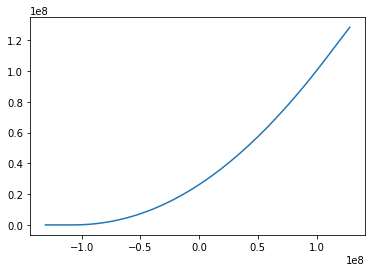

In [11]:
import matplotlib.pyplot as plt
plt.plot(deltaH_list, Ea_list)

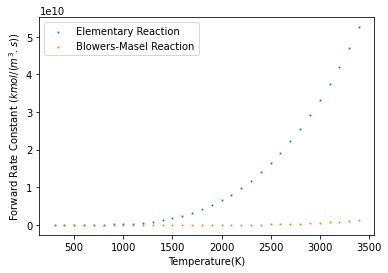

In [22]:
r1_kf= []
r2_kf = []
T_range = np.arange(300, 3500, 100)
for temp in T_range:
    gas.TP = temp, ct.one_atm
    r1_kf.append(gas.forward_rate_constants[0])
    r2_kf.append(gas.forward_rate_constants[1])
plt.scatter(T_range, r1_kf, 1*1, label='Elementary Reaction')
plt.scatter(T_range, r2_kf, 1*1, label='Blowers-Masel Reaction')
plt.xlabel("Temperature(K)")
plt.ylabel("Forward Rate Constant $(kmol/(m^3.s))$")
plt.legend()
# plt.savefig('bm.pdf')

The first and second reactions have same reaction equation, but they have different reaction types, so the forward rate constant of the first reaction is 5195.447 kmol/(m^3.s), the forward rate constant of the second reaction is 946.051 kmol/(m^3.s).
The rate parameters of second and the third reactions are same, but the forward rate cosntant of second reaction is 946.051 kmol/(m^3.s), the forward rate constant of the third reaction is 2533.800 kmol/(m^3.s).


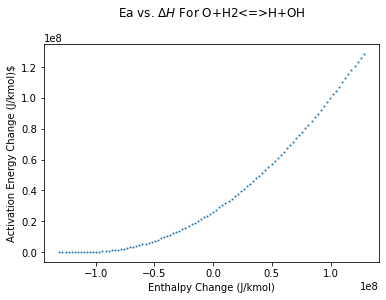

In [7]:
"""
A simplest example to demonstrate the difference between Blowers-Masel
reaction and elementary reaction. The first two reactions have same reaction 
equations with Arrhenius and Blowers-Masel rate parameters, respectively. 
The Blowers-Masel parameters are same as Arrhenius parameters with an 
additional value, bond energy. First we show that the forward rate constants 
of the first 2 different reactions are different because of the different rate
expression, then we print the forward rate constants for reaction 2 and reaction 3
to show that even 2 reactions have same Blowers-Masel parameters can have different
forward rate constants. The first plot generated shows the rate constant changes
with respect to temperature for elementary and Blower-Masel reactions are different.
The second plot shows the activation energy change of a Blowers-Masel reaction 
with respect to the delta enthalpy of the reaction.
"""

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

#Create an elementary reaction O+H2<=>H+OH
r1 = ct.ElementaryReaction({'O':1, 'H2':1}, {'H':1, 'OH':1})
r1.rate = ct.Arrhenius(3.87e1, 2.7, 6260*1000*4.184)

#Create a Blowers-Masel reaction O+H2<=>H+OH
r2 = ct.BlowersMaselReaction({'O':1, 'H2':1}, {'H':1, 'OH':1})
r2.rate = ct.BlowersMasel(3.87e1, 2.7, 6260*1000*4.184, 1e9)

#Create a Blowers-Masel reaction with same parameters with r2
#reaction equation is H+CH4<=>CH3+H2
r3 = ct.BlowersMaselReaction({'H':1, 'CH4':1}, {'CH3':1, 'H2':1})
r3.rate = ct.BlowersMasel(3.87e1, 2.7, 6260*1000*4.184, 1e9)

gas = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                   species=ct.Solution('gri30.yaml').species(), reactions=[r1, r2, r3])

gas.TP = 300, ct.one_atm

r1_rc = gas.forward_rate_constants[0]
r2_rc = gas.forward_rate_constants[1]
r3_rc = gas.forward_rate_constants[2]

print("The first and second reactions have same reaction equation,"
      " but they have different reaction types, so the forward rate"
      " constant of the first reaction is {0:.3f} kmol/(m^3.s),"
      " the forward rate constant of the second reaction is {1:.3f} kmol/(m^3.s).".format(r1_rc, r2_rc))

print("The rate parameters of second and the third reactions are same,"
      " but the forward rate cosntant of second reaction is {0:.3f} kmol/(m^3.s),"
      " the forward rate constant of the third reaction is"
      " {1:.3f} kmol/(m^3.s).".format(r2_rc, r3_rc))

# Comparing the reaction forward rate constant change of
# Blowers-Masel reaction and elementary reaction with
# respect to the temperature.
r1_kf = []
r2_kf = []
T_range = np.arange(300, 3500, 100)
for temp in T_range:
    gas.TP = temp, ct.one_atm
    r1_kf.append(gas.forward_rate_constants[0])
    r2_kf.append(gas.forward_rate_constants[1])
plt.scatter(T_range, r1_kf, 1*1, label='Reaction 1 (Elementary)')
plt.scatter(T_range, r2_kf, 1*1, label='Reaction 2 (Blowers-Masel)')
plt.xlabel("Temperature(K)")
plt.ylabel("Forward Rate Constant $(kmol/(m^3.s))$")
plt.title("Comparison Of kf vs. Temperature For Reaction 1 and 2",y=1.1)
plt.legend()
# plt.show()
plt.savefig('kf.png')
plt.clf()

# This is the function to change the enthalpy of a species
# so that the enthalpy change of reactions involving this
#species can be changed
def change_species_enthalpy(gas, species_name, dH):
    """
    Find the species by name and change it's enthlapy by dH (in J/kmol)
    """
    index = gas.species_index(species_name)

    species = gas.species(index)
    # 'dx' is in fact (delta H / R). Note that R in cantera is 8314.462 J/kmol
    dx = dH / ct.gas_constant
    perturbed_coeffs = species.thermo.coeffs.copy()
    perturbed_coeffs[6] += dx
    perturbed_coeffs[13] += dx

    species.thermo = ct.NasaPoly2(species.thermo.min_temp, species.thermo.max_temp, 
                            species.thermo.reference_pressure, perturbed_coeffs)

    gas.modify_species(index, species)

# Plot the activation energy change of reaction 2 with respect to the 
# enthalpy change
E0 = float(str(gas.reaction(1).rate).split()[-2][3:-1])
upper_limit_enthalpy = 5 * E0
lower_limit_enthalpy = -5 * E0

Ea_list = []
deltaH_list = np.arange(lower_limit_enthalpy, upper_limit_enthalpy, (upper_limit_enthalpy-lower_limit_enthalpy)/100)
for deltaH in deltaH_list:
    change_species_enthalpy(gas, 'H', deltaH - gas.delta_enthalpy[1])
    Ea_list.append(gas.reaction(1).rate.activation_energy(gas.delta_enthalpy[1]))

plt.scatter(deltaH_list, Ea_list, 1)
plt.xlabel("Enthalpy Change (J/kmol)")
plt.ylabel("Activation Energy Change (J/kmol)$")
plt.title("Ea vs. $\Delta H$ For O+H2<=>H+OH", y=1.1)
plt.savefig('Ea.png')